In [147]:
import gpytorch
from matplotlib import pyplot as plt
import numpy as np
import torch
from torcheval.metrics.functional import r2_score

from src.env.bikes import Bikes

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Load env dataset and preprocess

In [148]:
buffer=np.load("datasets/Bikes/None/replay_buffer.npz")
next_obs = torch.tensor(buffer["next_obs"], dtype=torch.float32)
obs = torch.tensor(buffer["obs"], dtype=torch.float32)
act = torch.round(torch.tensor(buffer["action"], dtype=torch.float32))
reward = torch.tensor(buffer["reward"], dtype=torch.float32)
print(obs.shape, act.shape)

num_centroids = 43
map_obs = {
    "bikes_distr": slice(0, num_centroids),
    "day": slice(num_centroids, 44),
    "month": slice(44, 45),
    "timecounter": slice(45, 46),
}
num_trucks = act.shape[-1]//2
map_act={
    "truck_centroid": slice(0, num_trucks),
    "truck_num_bikes": slice(num_trucks, 2*num_trucks),
}

print(map_obs, map_act)

torch.Size([10000, 46]) torch.Size([10000, 10])
{'bikes_distr': slice(0, 43, None), 'day': slice(43, 44, None), 'month': slice(44, 45, None), 'timecounter': slice(45, 46, None)} {'truck_centroid': slice(0, 5, None), 'truck_num_bikes': slice(5, 10, None)}


Compute delta bikes and obs += delta_bikes

In [149]:
obs_before_action = obs.clone()

resize = False
while obs.ndim < 3:
    assert act.ndim == obs.ndim
    obs = obs[None, ...]
    act = act[None, ...]
    resize = True

ensemble_size = obs.shape[0]
batch_size = obs.shape[1]
distr_size = len(obs[0, 0, map_obs["bikes_distr"]]) #self.map_obs["bikes_distr"]

# Compute delta_bikes in a parallel way
delta_bikes = np.zeros((ensemble_size, batch_size, distr_size), dtype=int)
truck_centroids = act[..., map_act["truck_centroid"]] #self.map_act["truck_centroid"]
truck_bikes = act[..., map_act["truck_num_bikes"]] #self.map_act["truck_num_bikes"]
n = distr_size
truck_centroids = np.reshape(
    truck_centroids, (truck_centroids.shape[0] * truck_centroids.shape[1], -1)
)
offset = np.arange(truck_centroids.shape[0])[..., None]
truck_centroids_offset = truck_centroids + offset * n
unq, inv = np.unique(truck_centroids_offset.ravel(), return_inverse=True)
unq = unq.astype(int)
sol = np.bincount(inv, truck_bikes.ravel())
delta_bikes[
    unq // (batch_size * n),
    (unq % (batch_size * n)) // n,
    (unq % (batch_size * n)) % n,
] = sol

if resize:
    delta_bikes = delta_bikes.reshape((batch_size, -1))
    act = act.reshape((batch_size, -1))
    obs = obs.reshape((batch_size, -1))

# Update obs
obs[..., map_obs["bikes_distr"]] += delta_bikes #self.map_obs["bikes_distr"]

print(torch.sum(obs-obs_before_action, axis=-1))
print(torch.sum(act[...,map_act["truck_num_bikes"]], axis=-1))

assert torch.all(torch.sum(obs-obs_before_action, axis=-1) == torch.sum(act[...,map_act["truck_num_bikes"]], axis=-1))

# Super long check to see if preprocess is good, and it is so far
# for obs_, previous_obs_, truck_centroids, truck_num_bikes in zip(obs, obs_before_action, act[...,truck_centroid_idx], act[...,truck_num_bikes_idx]):
#     bikes_idx = torch.nonzero(truck_num_bikes, as_tuple=True)[0]
#     truck_centroids = truck_centroids[bikes_idx]
#     centroids_new_bikes = torch.nonzero(obs_-previous_obs_, as_tuple=True)[0]
#     print(torch.sort(centroids_new_bikes).values)
#     print(torch.unique(truck_centroids))
#     print(torch.sort(centroids_new_bikes).values in torch.unique(truck_centroids))


tensor([13., 10., 18.,  ..., 11., 13., 10.])
tensor([13., 10., 18.,  ..., 11., 13., 10.])


Create x and y from obs and next_obs

In [150]:
dataset_size = 1000
input_obs_keys = ["bikes_distr", "timecounter"]
#input_act_keys = [] not implemented
output_keys = ["bikes_distr"]

input_mask = np.zeros(obs.shape[-1])
for key in input_obs_keys:
    input_mask[map_obs[key]] = 1
input_mask = np.ma.make_mask(input_mask)

output_mask = np.zeros(obs.shape[-1])
for key in output_keys:
    output_mask[map_obs[key]] = 1
output_mask = np.ma.make_mask(output_mask)

assert obs.ndim == 2
assert next_obs.ndim == 2
x = obs[:dataset_size, input_mask]
y = next_obs[:dataset_size, output_mask]

print(x.shape, y.shape)

torch.Size([1000, 44]) torch.Size([1000, 43])


Additional input features

In [151]:
#Maybe add a date proxy, weather ? holiday, week-end ??

Additional output preds (e.g. reward)

In [152]:
reward_ = reward[:dataset_size, ...].unsqueeze(-1)
print(y.shape, reward_.shape)
y = torch.cat([y, reward_], dim=-1)
print(y.shape)

torch.Size([1000, 43]) torch.Size([1000, 1])
torch.Size([1000, 44])


Split into train_x, test_x and train_y, test_y

In [153]:
test_split_ratio = 0.2

torch.manual_seed(0)
idx = torch.randperm(x.shape[0])
x = x[idx, :]
y = y[idx, :]

train_x = x[int(test_split_ratio*dataset_size):, ...]
train_y = y[int(test_split_ratio*dataset_size):, ...]
test_x = x[:int(test_split_ratio*dataset_size), ...]
test_y = y[:int(test_split_ratio*dataset_size), ...]

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

torch.Size([800, 44]) torch.Size([800, 44]) torch.Size([200, 44]) torch.Size([200, 44])


### 2. Train model

Linear regression

In [154]:
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [155]:
learningRate = 0.01 
epochs = 2000
eval_epoch_freq = 1
in_size=train_x.shape[-1]
out_size=train_y.shape[-1]
device="cpu"
model = linearRegression(in_size, out_size)
criterion = torch.nn.MSELoss()
metric = r2_score
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

In [156]:
train_losses = []
test_losses = []
train_metrics = []
test_metrics = []
for epoch in range(epochs):
    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(train_x)

    # get loss for the predicted output
    loss = criterion(outputs, train_y)
    train_losses.append(loss.item())
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    #Compute metric
    train_metric = metric(outputs, train_y)
    train_metrics.append(train_metric)

    print('epoch {}, loss {}, R2 {}'.format(epoch, loss.item(), train_metric))

    if epoch%eval_epoch_freq==0:
        with torch.no_grad(): # we don't need gradients in the testing phase
            preds = model(test_x)
            test_loss = criterion(preds, test_y)
            test_losses.append(test_loss.item())
            #Compute metric
            test_metric = metric(preds, test_y)
            test_metrics.append(test_metric)
            print('Eval loss {}, R2 {}'.format(loss.item(), test_metric))

epoch 0, loss 7.614243507385254, R2 -2.497022867202759
Eval loss 7.614243507385254, R2 -2.4996373653411865
epoch 1, loss 7.293863773345947, R2 -2.3893167972564697
Eval loss 7.293863773345947, R2 -2.394082546234131
epoch 2, loss 7.0016045570373535, R2 -2.2907192707061768
Eval loss 7.0016045570373535, R2 -2.297515869140625
epoch 3, loss 6.73488187789917, R2 -2.2003934383392334
Eval loss 6.73488187789917, R2 -2.209111452102661
epoch 4, loss 6.4913458824157715, R2 -2.117582321166992
Eval loss 6.4913458824157715, R2 -2.1281168460845947
epoch 5, loss 6.268867492675781, R2 -2.041595458984375
Eval loss 6.268867492675781, R2 -2.0538525581359863
epoch 6, loss 6.065511226654053, R2 -1.9718090295791626
Eval loss 6.065511226654053, R2 -1.98569917678833
epoch 7, loss 5.879520416259766, R2 -1.9076546430587769
Eval loss 5.879520416259766, R2 -1.923094630241394
epoch 8, loss 5.7093024253845215, R2 -1.8486170768737793
Eval loss 5.7093024253845215, R2 -1.8655303716659546
epoch 9, loss 5.553407669067383, 

epoch 471, loss 1.3375983238220215, R2 0.32891929149627686
Eval loss 1.3375983238220215, R2 0.26080071926116943
epoch 472, loss 1.335727334022522, R2 0.3300713300704956
Eval loss 1.335727334022522, R2 0.26198896765708923
epoch 473, loss 1.333863377571106, R2 0.3312191069126129
Eval loss 1.333863377571106, R2 0.26317301392555237
epoch 474, loss 1.3320066928863525, R2 0.33236268162727356
Eval loss 1.3320066928863525, R2 0.2643528878688812
epoch 475, loss 1.330156922340393, R2 0.333501935005188
Eval loss 1.330156922340393, R2 0.2655286192893982
epoch 476, loss 1.3283143043518066, R2 0.3346370458602905
Eval loss 1.3283143043518066, R2 0.2667001783847809
epoch 477, loss 1.3264787197113037, R2 0.3357678949832916
Eval loss 1.3264787197113037, R2 0.26786765456199646
epoch 478, loss 1.3246500492095947, R2 0.33689454197883606
Eval loss 1.3246500492095947, R2 0.26903098821640015
epoch 479, loss 1.3228285312652588, R2 0.3380171060562134
Eval loss 1.3228285312652588, R2 0.2701902389526367
epoch 480

Plot losses

<Figure size 640x480 with 0 Axes>

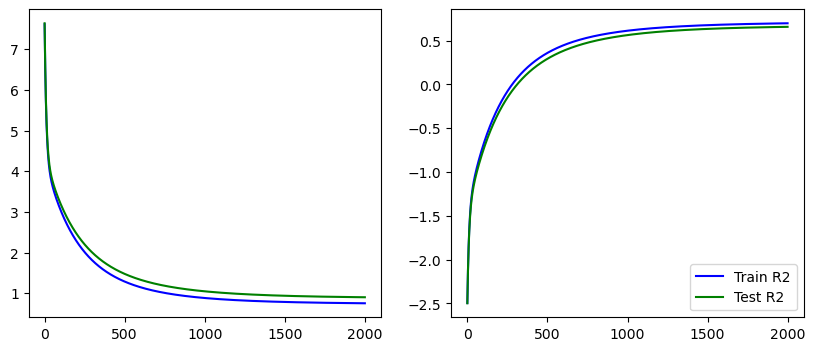

In [157]:
plt.clf()
f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(train_losses, 'b', label='Training loss')
ax[0].plot(test_losses, 'g', label='Test loss')
ax[1].plot(train_metrics, 'b', label='Train R2')
ax[1].plot(test_metrics, 'g', label='Test R2')
plt.legend(loc='best')
plt.show()

<Figure size 640x480 with 0 Axes>

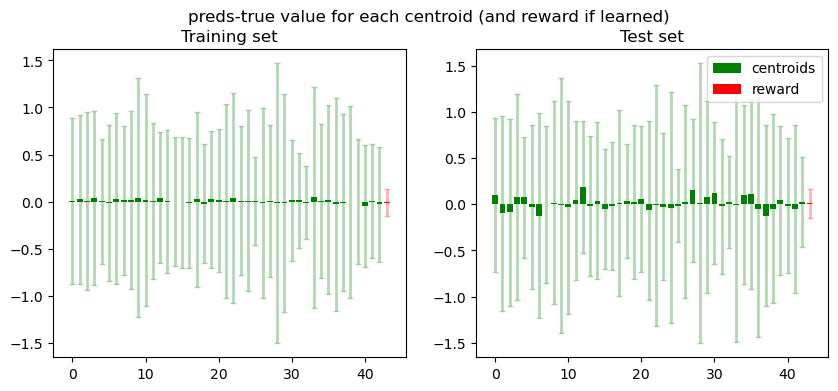

In [158]:
with torch.no_grad(): # we don't need gradients in the testing phase
    train_preds = model(train_x)
    test_preds = model(test_x)

relative_train_preds_mean = torch.mean(train_preds - train_y, axis=0)
relative_train_preds_std = torch.std(train_preds - train_y, axis=0)
relative_test_preds_mean = torch.mean(test_preds - test_y, axis=0)
relative_test_preds_std = torch.std(test_preds - test_y, axis=0)

plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

#Colors and labels
if len(relative_train_preds_mean)<num_centroids:
    raise ValueError("Predicted outputs are weird")
if len(relative_train_preds_mean)==num_centroids:
    color="green"
    label='centroids'
else:
    colors=["green"]*num_centroids
    colors.append("red")
    label=["centroids"]*num_centroids
    label.append("reward")

#Train bar plots
x = torch.arange(0, len(relative_train_preds_mean), 1)
ax[0].bar(
    x,
    relative_train_preds_mean,
    color=colors,
    label=label
)
for pos, y, err, color in zip(x, relative_train_preds_mean, relative_train_preds_std, colors):
    ax[0].errorbar(pos, y, err, lw = 2,capsize = 2, capthick = 1, color = color, alpha=0.3)
    # error_kw=dict(ecolor=colors, lw=1, capsize=1, capthick=2, alpha=0.5),
ax[0].title.set_text('Training set')

#Test bar plots
ax[1].bar(
    x,
    relative_test_preds_mean,
    color=colors,
    label=label
)
for pos, y, err, color in zip(x, relative_test_preds_mean, relative_test_preds_std, colors):
    ax[1].errorbar(pos, y, err, lw = 2,capsize = 2, capthick = 1, color = color, alpha=0.3)
ax[1].title.set_text('Test set')

fig.suptitle("preds-true value for each centroid (and reward if learned)")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')
plt.show()

Neural Network

In [159]:
from src.model.simple import Simple

#Hyperparams
learningRate = 0.001
weight_decay = 0
optim_eps = 1e-8

epochs = 500
batch_size = 256
eval_epoch_freq = 1
in_size=train_x.shape[-1]
out_size=train_y.shape[-1]
device="cpu"
model = Simple(in_size, out_size, device)
criterion = torch.nn.MSELoss()
metric = r2_score
optimizer = torch.optim.Adam(
                model.parameters(),
                lr=learningRate,
                weight_decay=weight_decay,
                eps=optim_eps,
            )
#torch.optim.SGD(model.parameters(), lr=learningRate)

In [160]:
train_losses = []
test_losses = []
train_metrics = []
test_metrics = []
for epoch in range(epochs):
    k = 0
    l = batch_size
    batch_loss = []
    while l < train_x.shape[0]:
        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()

        # get output from the model, given the inputs
        outputs = model(train_x)

        # get loss for the predicted output
        loss = criterion(outputs, train_y)
        batch_loss.append(loss.item())
        # get gradients w.r.t to parameters
        loss.backward()

        # update parameters
        optimizer.step()

        #Update k,l
        k = l
        l = min(l+batch_size, train_x.shape[0])

    #Append train loss
    train_losses.append(np.mean(batch_loss))

    #Compute metric
    train_metric = metric(outputs, train_y)
    train_metrics.append(train_metric)

    print('epoch {}, loss {}, R2 {}'.format(epoch, loss.item(), train_metric))

    if epoch%eval_epoch_freq==0:
        with torch.no_grad(): # we don't need gradients in the testing phase
            preds = model(test_x)
            test_loss = criterion(preds, test_y)
            test_losses.append(test_loss.item())
            #Compute metric
            test_metric = metric(preds, test_y)
            test_metrics.append(test_metric)
            print('Eval loss {}, R2 {}'.format(loss.item(), test_metric))

epoch 0, loss 5.323896408081055, R2 -0.4018963575363159
Eval loss 5.323896408081055, R2 -0.40800949931144714
epoch 1, loss 4.939913272857666, R2 -0.25594255328178406
Eval loss 4.939913272857666, R2 -0.18786725401878357
epoch 2, loss 3.9092791080474854, R2 -0.16295231878757477
Eval loss 3.9092791080474854, R2 -0.604037344455719
epoch 3, loss 3.834420680999756, R2 -0.7803119421005249
Eval loss 3.834420680999756, R2 -0.4473435580730438
epoch 4, loss 3.371290445327759, R2 0.05224437639117241
Eval loss 3.371290445327759, R2 0.07332278043031693
epoch 5, loss 3.4254508018493652, R2 0.06424520909786224
Eval loss 3.4254508018493652, R2 0.05064111575484276
epoch 6, loss 3.348079204559326, R2 0.045901037752628326
Eval loss 3.348079204559326, R2 0.02455156482756138
epoch 7, loss 3.3848602771759033, R2 0.025363124907016754
Eval loss 3.3848602771759033, R2 0.016881713643670082
epoch 8, loss 3.3062312602996826, R2 0.046125736087560654
Eval loss 3.3062312602996826, R2 0.04103560000658035
epoch 9, loss

<Figure size 640x480 with 0 Axes>

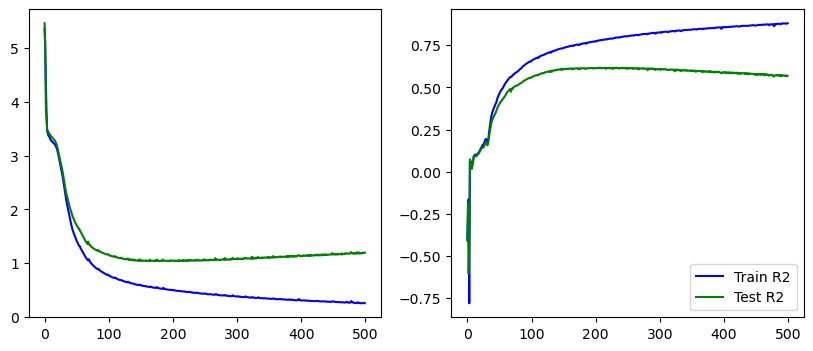

In [161]:
plt.clf()
f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(train_losses, 'b', label='Training loss')
ax[0].plot(test_losses, 'g', label='Test loss')
ax[1].plot(train_metrics, 'b', label='Train R2')
ax[1].plot(test_metrics, 'g', label='Test R2')
plt.legend(loc='best')
plt.show()

<Figure size 640x480 with 0 Axes>

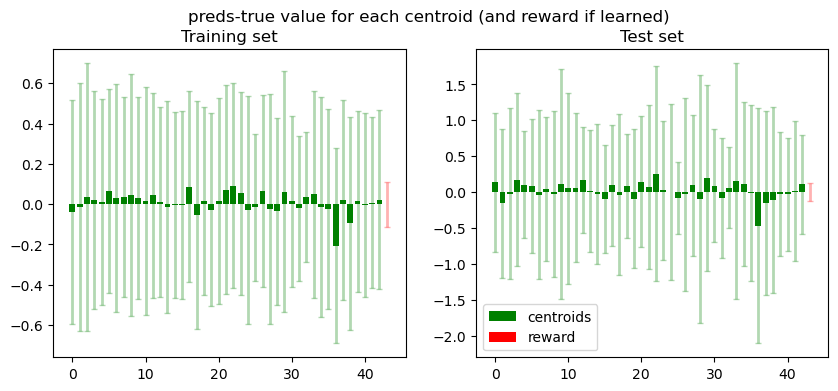

In [162]:
with torch.no_grad(): # we don't need gradients in the testing phase
    train_preds = model(train_x)
    test_preds = model(test_x)

relative_train_preds_mean = torch.mean(train_preds - train_y, axis=0)
relative_train_preds_std = torch.std(train_preds - train_y, axis=0)
relative_test_preds_mean = torch.mean(test_preds - test_y, axis=0)
relative_test_preds_std = torch.std(test_preds - test_y, axis=0)

plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

#Colors and labels
if len(relative_train_preds_mean)<num_centroids:
    raise ValueError("Predicted outputs are weird")
if len(relative_train_preds_mean)==num_centroids:
    color="green"
    label='centroids'
else:
    colors=["green"]*num_centroids
    colors.append("red")
    label=["centroids"]*num_centroids
    label.append("reward")

#Train bar plots
x = torch.arange(0, len(relative_train_preds_mean), 1)
ax[0].bar(
    x,
    relative_train_preds_mean,
    color=colors,
    label=label
)
for pos, y, err, color in zip(x, relative_train_preds_mean, relative_train_preds_std, colors):
    ax[0].errorbar(pos, y, err, lw = 2,capsize = 2, capthick = 1, color = color, alpha=0.3)
    # error_kw=dict(ecolor=colors, lw=1, capsize=1, capthick=2, alpha=0.5),
ax[0].title.set_text('Training set')

#Test bar plots
ax[1].bar(
    x,
    relative_test_preds_mean,
    color=colors,
    label=label
)
for pos, y, err, color in zip(x, relative_test_preds_mean, relative_test_preds_std, colors):
    ax[1].errorbar(pos, y, err, lw = 2,capsize = 2, capthick = 1, color = color, alpha=0.3)
ax[1].title.set_text('Test set')

fig.suptitle("preds-true value for each centroid (and reward if learned)")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')
plt.show()

Gaussian process

In [163]:
from src.model.gaussian_process import MultiOutputGP

#Hyperparams
learningRate = 0.1
weight_decay = 0
optim_eps = 1e-8
mean = "Linear"
kernel = "Linear"

epochs = 50
eval_epoch_freq = 1
in_size=train_x.shape[-1]
out_size=train_y.shape[-1]
device="cpu"
model = MultiOutputGP(in_size, out_size, device, mean, kernel)
mll = gpytorch.mlls.SumMarginalLogLikelihood(model.likelihood, model.gp)
metric = r2_score
optimizer = torch.optim.Adam(
                model.parameters(),
                lr=learningRate,
                weight_decay=weight_decay,
                eps=optim_eps,
            )
#torch.optim.SGD(model.parameters(), lr=learningRate)

dataset_size_gp = 1000
gp_idx_split = int(test_split_ratio*dataset_size_gp)

train_x_gp = train_x[gp_idx_split:dataset_size_gp, ...]
train_y_gp = train_y[gp_idx_split:dataset_size_gp, ...]
test_x_gp = test_x[:gp_idx_split, ...]
test_y_gp = test_y[:gp_idx_split, ...]

print(train_x_gp.shape, train_y_gp.shape, test_x_gp.shape, test_y_gp.shape)

torch.Size([600, 44]) torch.Size([600, 44]) torch.Size([200, 44]) torch.Size([200, 44])


In [164]:
train_losses = []
test_losses = []
train_metrics = []
test_metrics = []
for epoch in range(epochs):
    #Set training mode REQUIRED FOR GP
    model.gp.train()

    #Set the training data
    if epoch==0:
        model.set_train_data(train_x_gp, train_y_gp)

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model.forward()

    # get loss for the predicted output
    loss = -mll(outputs, model.gp.train_targets)
    train_losses.append(loss.item())
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    #Compute metric
    train_pred_output = model.likelihood(*outputs)
    train_pred_mean = torch.cat(
        [pred.mean.unsqueeze(-1) for pred in train_pred_output], axis=-1
    )
    train_metric = metric(train_pred_mean, train_y_gp)
    train_metrics.append(train_metric)

    print('epoch {}, loss {}, R2 {}'.format(epoch, loss.item(), train_metric))

    if epoch%eval_epoch_freq==0:
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            model.gp.eval()
            model.likelihood.eval()
            preds = model.forward(test_x_gp)
            test_loss = -mll(preds, [test_y_gp[..., i] for i in range(len(model.gp.models))])
            test_losses.append(test_loss.item())
            #Compute metric
            test_pred_output = model.likelihood(*preds)
            test_pred_mean = torch.cat(
                [pred.mean.unsqueeze(-1) for pred in test_pred_output], axis=-1
            )
            test_metric = metric(test_pred_mean, test_y_gp)
            test_metrics.append(test_metric)
            print('Eval loss {}, R2 {}'.format(loss.item(), test_metric))

epoch 0, loss 1.665695071220398, R2 -193.2993621826172
Eval loss 1.665695071220398, R2 0.3234846889972687
epoch 1, loss 1.6216813325881958, R2 -172.3352508544922
Eval loss 1.6216813325881958, R2 0.3712581694126129
epoch 2, loss 1.5875122547149658, R2 -147.14016723632812
Eval loss 1.5875122547149658, R2 0.41509801149368286
epoch 3, loss 1.560895562171936, R2 -124.4258041381836
Eval loss 1.560895562171936, R2 0.4552282989025116
epoch 4, loss 1.539678931236267, R2 -105.1559829711914
Eval loss 1.539678931236267, R2 0.49158209562301636
epoch 5, loss 1.5222197771072388, R2 -89.65971374511719
Eval loss 1.5222197771072388, R2 0.5242920517921448
epoch 6, loss 1.5074580907821655, R2 -77.09456634521484
Eval loss 1.5074580907821655, R2 0.5532590746879578
epoch 7, loss 1.4947861433029175, R2 -66.50433349609375
Eval loss 1.4947861433029175, R2 0.5786527991294861
epoch 8, loss 1.4837571382522583, R2 -57.077491760253906
Eval loss 1.4837571382522583, R2 0.6005467772483826
epoch 9, loss 1.47398459911346

<Figure size 640x480 with 0 Axes>

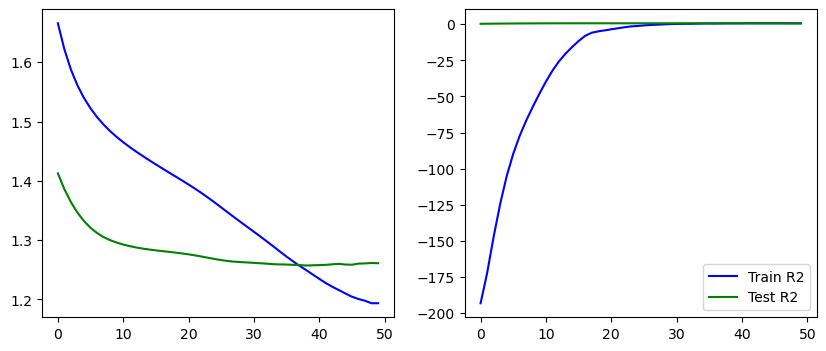

In [165]:
plt.clf()
f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(train_losses, 'b', label='Training loss')
ax[0].plot(test_losses, 'g', label='Test loss')
ax[1].plot(train_metrics, 'b', label='Train R2')
ax[1].plot(test_metrics, 'g', label='Test R2')
plt.legend(loc='best')
plt.show()

<Figure size 640x480 with 0 Axes>

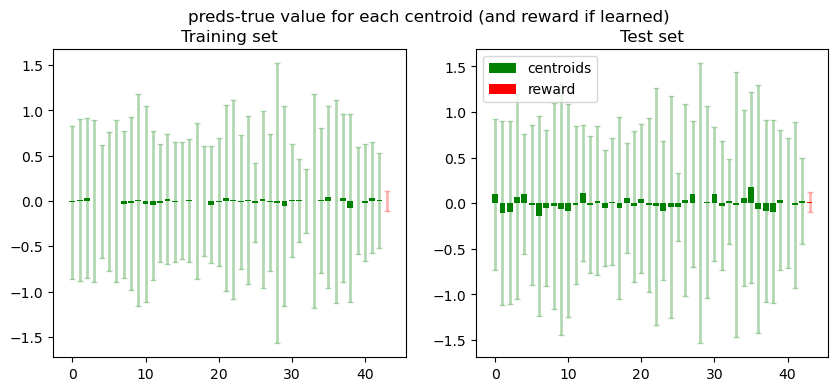

In [166]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    train_preds = model.likelihood(*model(train_x_gp))
    test_preds = model.likelihood(*model(test_x_gp))
    train_preds = torch.cat(
        [pred.mean.unsqueeze(-1) for pred in train_preds], axis=-1
    )
    test_preds = torch.cat(
        [pred.mean.unsqueeze(-1) for pred in test_preds], axis=-1
    )

relative_train_preds_mean = torch.mean(train_preds - train_y_gp, axis=0)
relative_train_preds_std = torch.std(train_preds - train_y_gp, axis=0)
relative_test_preds_mean = torch.mean(test_preds - test_y_gp, axis=0)
relative_test_preds_std = torch.std(test_preds - test_y_gp, axis=0)

plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

#Colors and labels
if len(relative_train_preds_mean)<num_centroids:
    raise ValueError("Predicted outputs are weird")
if len(relative_train_preds_mean)==num_centroids:
    color="green"
    label='centroids'
else:
    colors=["green"]*num_centroids
    colors.append("red")
    label=["centroids"]*num_centroids
    label.append("reward")

#Train bar plots
x = torch.arange(0, len(relative_train_preds_mean), 1)
ax[0].bar(
    x,
    relative_train_preds_mean,
    color=colors,
    label=label
)
for pos, y, err, color in zip(x, relative_train_preds_mean, relative_train_preds_std, colors):
    ax[0].errorbar(pos, y, err, lw = 2,capsize = 2, capthick = 1, color = color, alpha=0.3)
    # error_kw=dict(ecolor=colors, lw=1, capsize=1, capthick=2, alpha=0.5),
ax[0].title.set_text('Training set')

#Test bar plots
ax[1].bar(
    x,
    relative_test_preds_mean,
    color=colors,
    label=label
)
for pos, y, err, color in zip(x, relative_test_preds_mean, relative_test_preds_std, colors):
    ax[1].errorbar(pos, y, err, lw = 2,capsize = 2, capthick = 1, color = color, alpha=0.3)
ax[1].title.set_text('Test set')

fig.suptitle("preds-true value for each centroid (and reward if learned)")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')
plt.show()

In [167]:
gp_id = 0

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    train_pred = model.likelihood.likelihoods[gp_id](model.gp.models[gp_id](train_x_gp))
    test_pred = model.likelihood.likelihoods[gp_id](model.gp.models[gp_id](test_x_gp))

    train_lower, train_upper = train_pred.confidence_region()
    mean_lower_train = np.mean(train_lower.numpy()-train_pred.mean.numpy())
    std_lower_train = np.std(train_lower.numpy()-train_pred.mean.numpy())
    mean_upper_train = np.mean(train_upper.numpy()-train_pred.mean.numpy())
    std_upper_train = np.std(train_upper.numpy()-train_pred.mean.numpy())
    test_lower, test_upper = test_pred.confidence_region()
    mean_lower_test = np.mean(test_lower.numpy()-test_pred.mean.numpy())
    std_lower_test = np.std(test_lower.numpy()-test_pred.mean.numpy())
    mean_upper_test = np.mean(test_upper.numpy()-test_pred.mean.numpy())
    std_upper_test = np.std(test_upper.numpy()-test_pred.mean.numpy())

    print(train_pred.mean.numpy().shape, test_pred.mean.numpy().shape)
    print(f"Lower train: {mean_lower_train}+-{std_lower_train}")
    print(f"Upper train: {mean_upper_train}+-{std_upper_train}")
    print(f"Lower train: {mean_lower_test}+-{std_lower_test}")
    print(f"Lower train: {mean_upper_test}+-{std_upper_test}")

(600,) (200,)
Lower train: -1.8210667371749878+-0.01887916587293148
Upper train: 1.8210667371749878+-0.01887916401028633
Lower train: -1.8232992887496948+-0.018743911758065224
Lower train: 1.8232992887496948+-0.01874392479658127
